## Forecasting, without fine-tuning

Initial idea behind the project was to utilize Maching Learing to predict alarming condition of a patient. As I described before I considered using Recurrent Neural Network for single time series forecasting and anomalies detection and Deep Neural Network for patient's condition stability determination. Last part of this project was to examine an example of the first of aforementioned approaches. Workflow is described in more detail in below cells:

At this stage I performed operations for a single parameter. I initially selected pulse, saturation and total breaths as most suitable ones.
Through consultations with a nurse consultant I determined that in case of all three of those time series anomalies take form of peaks on the graph. The Nurse consultant I worked with determined and marked anomalies locations on original series plots I provided.

The idea behind further work was to simulate the situation when:
1. First for specified number of hours patients observation data are collected
2. Then the Neural Network (NN) is trained on collected data
3. For further time steps NN predicts an expected parameter value and the real value is collected simultaneously
4. If collected value is significantly different than the NN predicted one an alert is raised

As described data are examples of time series I used long short-term memory (LSTM) Recurrent Neural Network which in the process of forecasting takes advantage of a sequence of previous time steps and has regard to their value.

For further steps I used pulse time series.
I compared 2 NN architectures. Both of them were proposed by my engineering thesis supervisor. He was also an author of initial script describing training, predicting and one parameter (one seq_len) results visualization operating on trial artificial series. I used this script as a basis which I modified.

Below I compared prediction results for:
1. 2 pulse time series (the original series and one series produced using augmentation method described earlier)
2. 2 model architectures 
3. multiple lengths of data sequences used form model training and prediction.

#### Models description:
1. LSTMForecaster - is a simple model consisting of one LSTM and one Linear layer. It has 64 features in the hidden state. And its output is a predicted next step value in a form of scalar.
2. LSTMAttentionForecaster - is a modification of a firs model. 2 additional Linear layers, Dropout mechanism and a ReLu activation function incorporated modifying preformed calculations. 


In [15]:
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append('../modules/')
from modules.NN_data_prep import set_seed, preprocess_series, prepare_dataset, plot_time_series
from modules.NN_models import LSTMForecaster, LSTMAttentionForecaster
from modules.NN_model_usage import train_model, model_predict, detect_anomalies, plot_results, create_saving_path

In [16]:
param = 'pulse'

df_aug = pd.read_csv('../../data/df_augmented_' + param + '.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_aug.set_index('date', inplace=True)
series_aug = df_aug['aug_series_00001']

df_original = pd.read_csv('../../data/df_stl_interpolated.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_original.set_index('date', inplace=True)
series_original = df_original[param]

In [17]:
print(series_aug.head(2))
print(series_original.head(2))

date
2023-11-13 14:00:00    122
2023-11-13 15:00:00    128
Name: aug_series_00001, dtype: int64
date
2023-11-13 14:00:00    125
2023-11-13 15:00:00    130
Name: pulse, dtype: int64


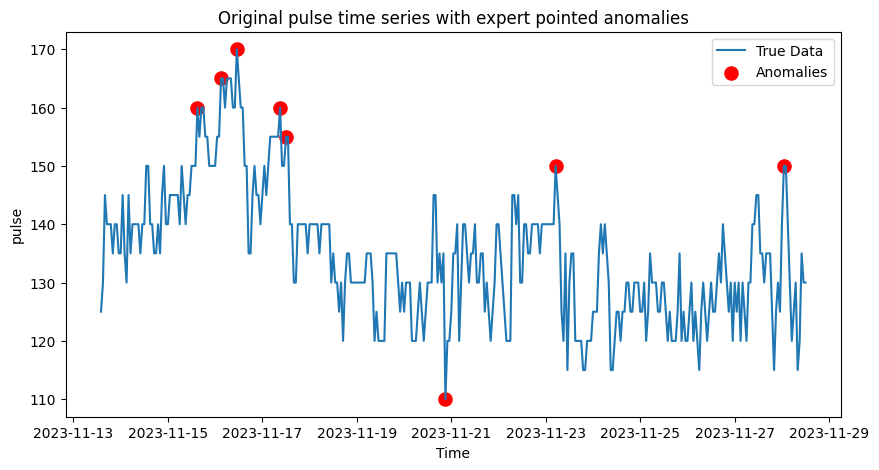

In [18]:
plot_time_series(series_original.index,
                 series_original.values,
                 anomalies=[49, 61, 69, 91, 94, 175, 231, 347],
                 parameter_name=param,
                 title="Original " + param + " time series with expert pointed anomalies",
                 values_normalised=False)

In [19]:
series_dict = {'series_original': series_original, 'series_aug': series_aug}
model_classes = [LSTMForecaster, LSTMAttentionForecaster]
seq_lengths = [2, 3, 5, 8, 12, 20]

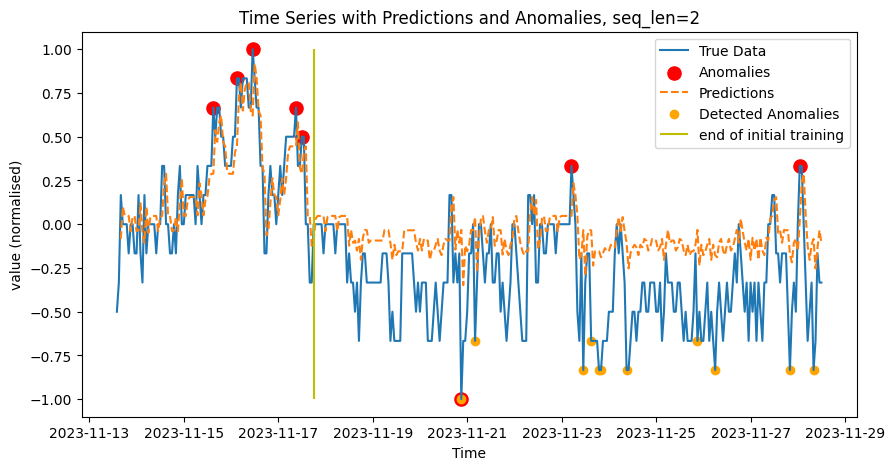

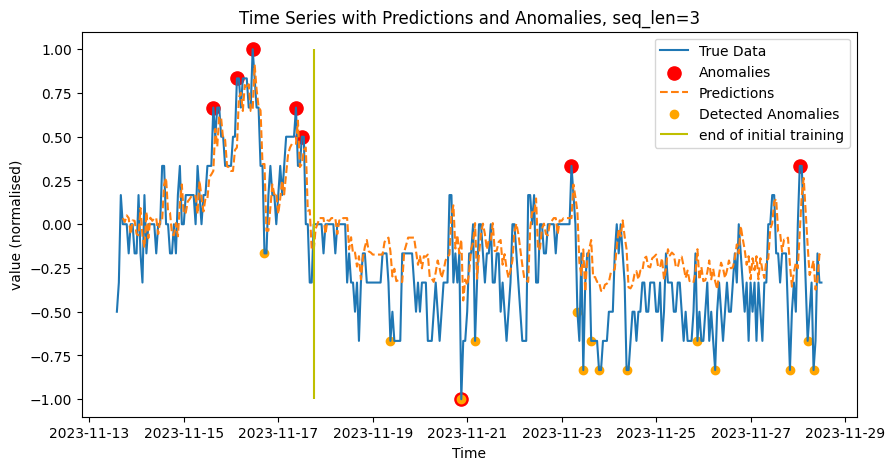

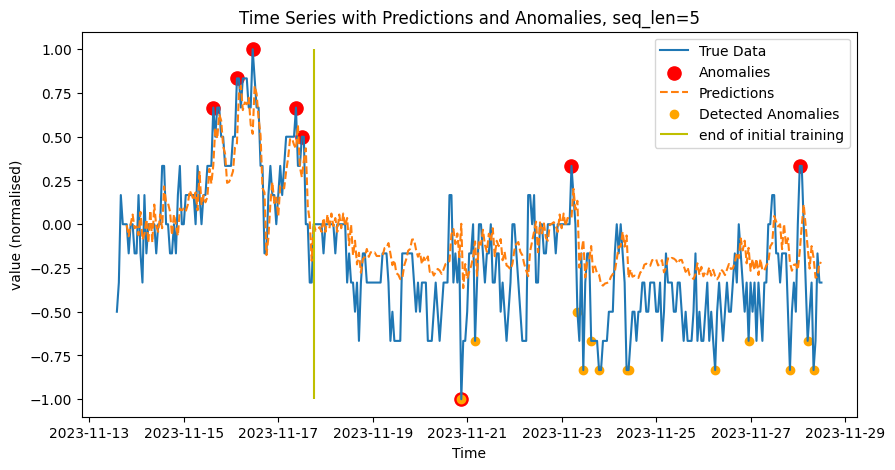

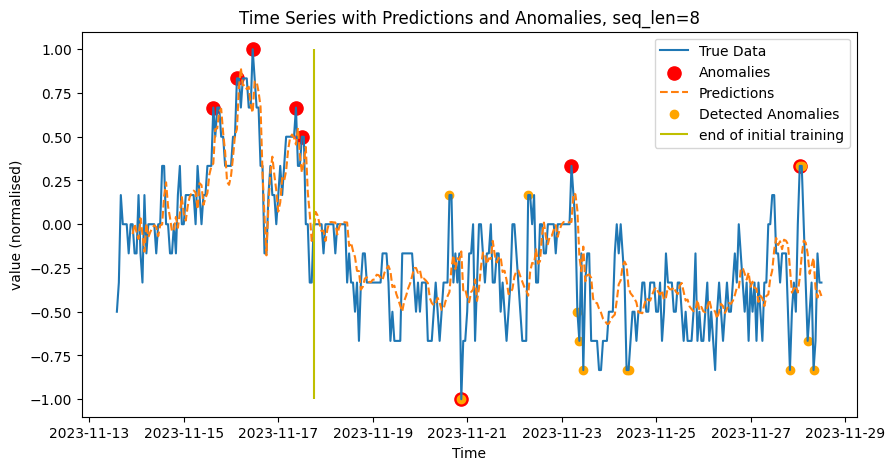

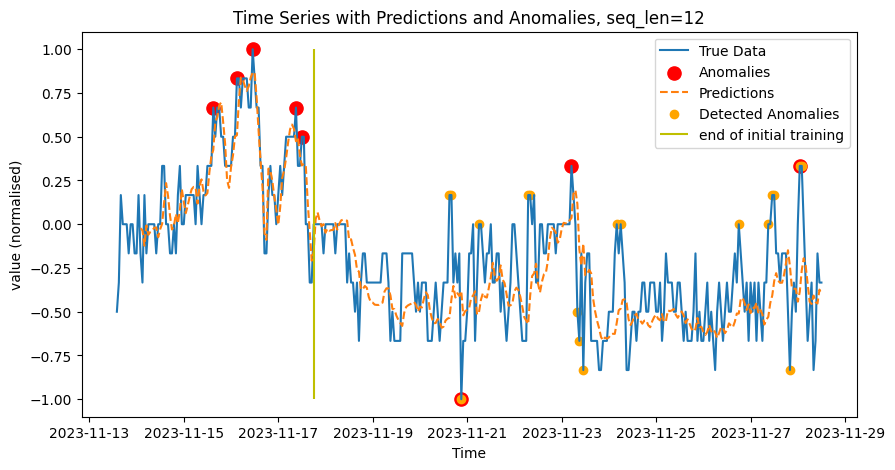

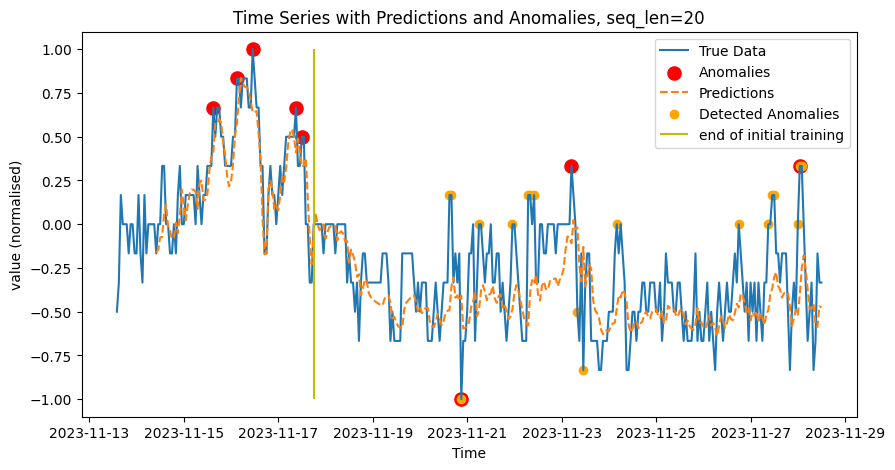

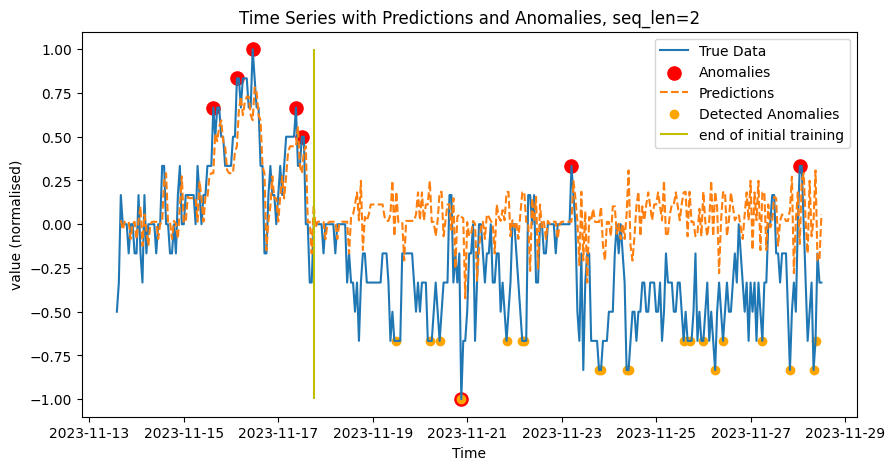

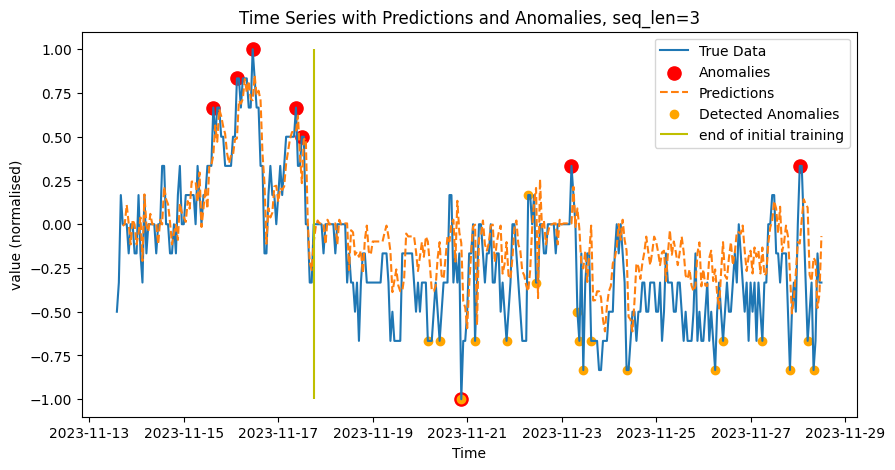

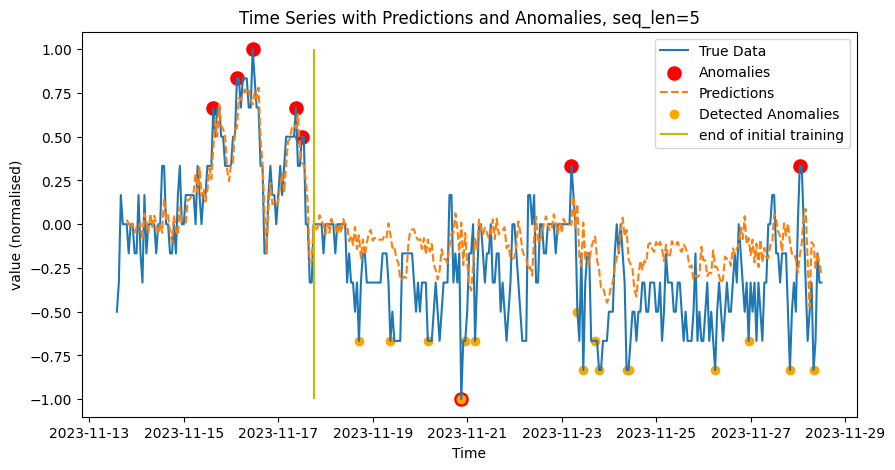

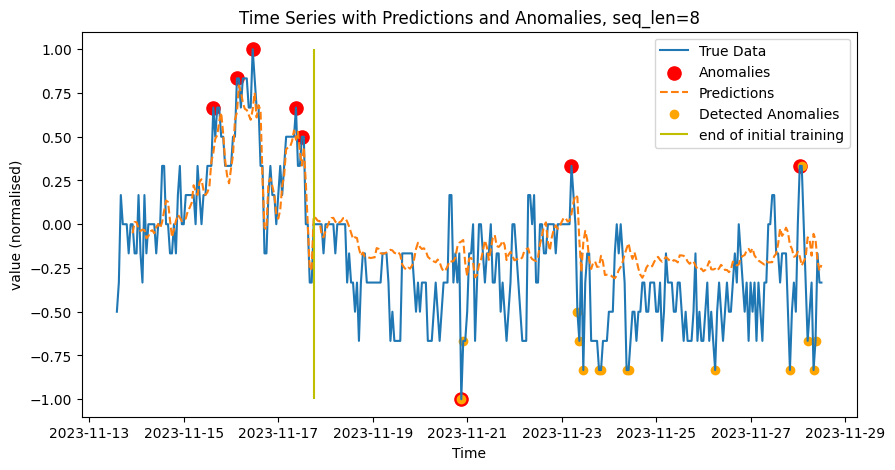

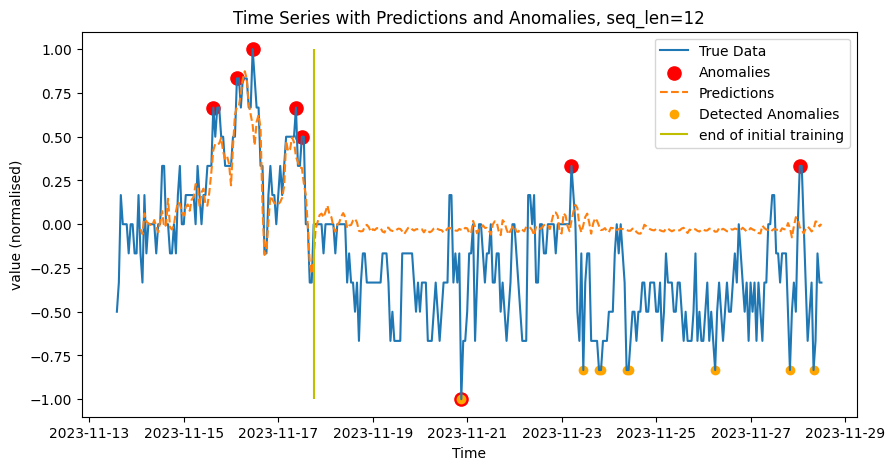

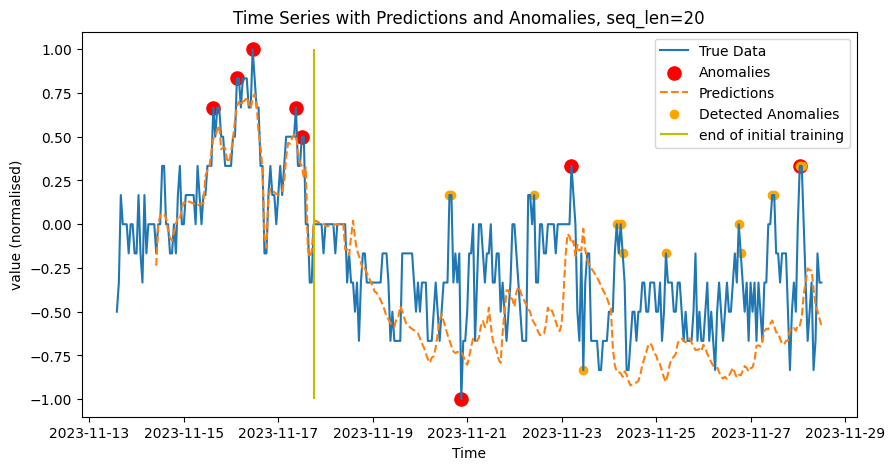

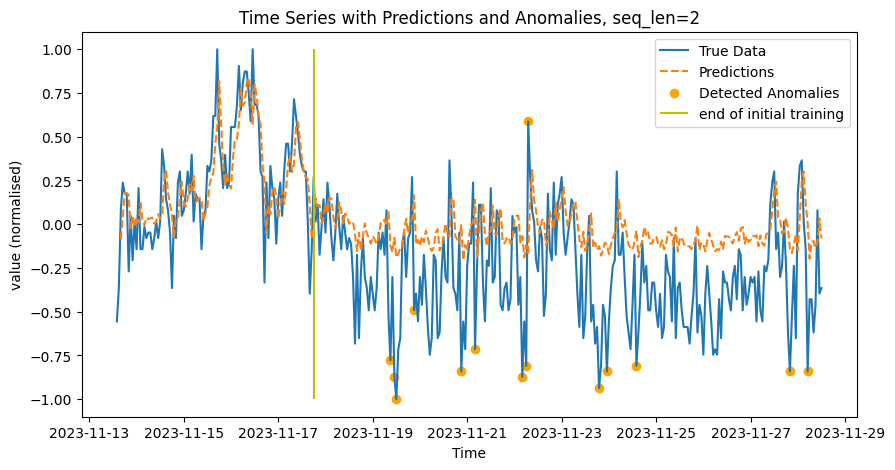

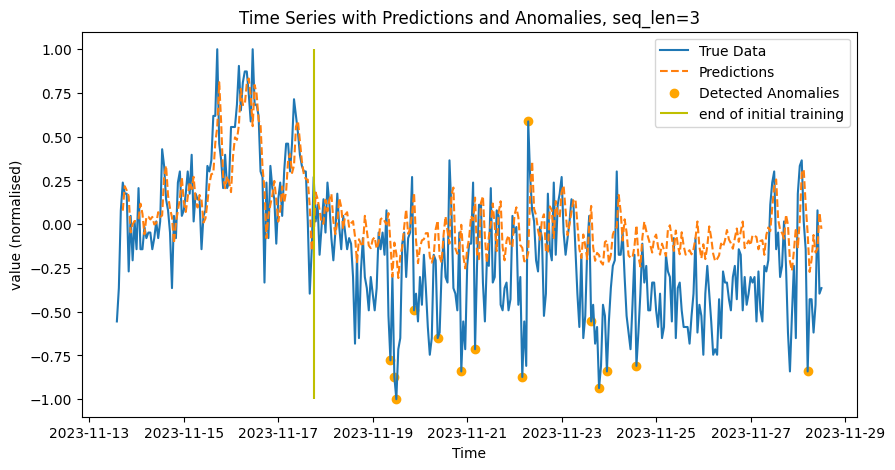

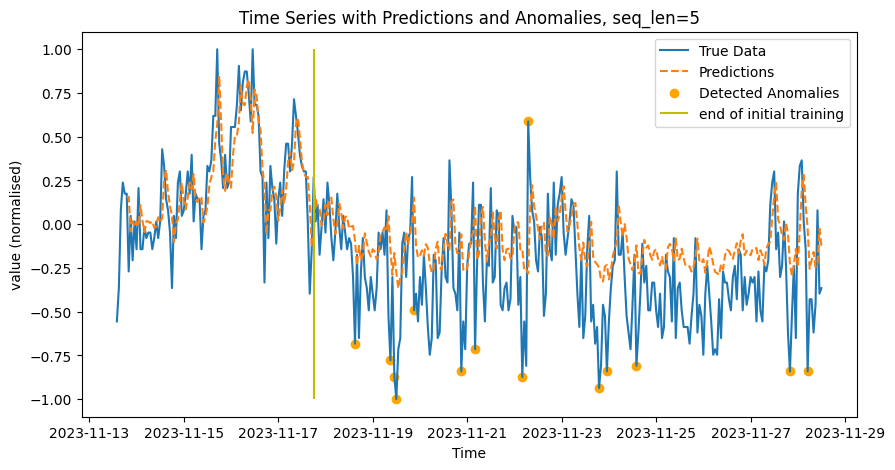

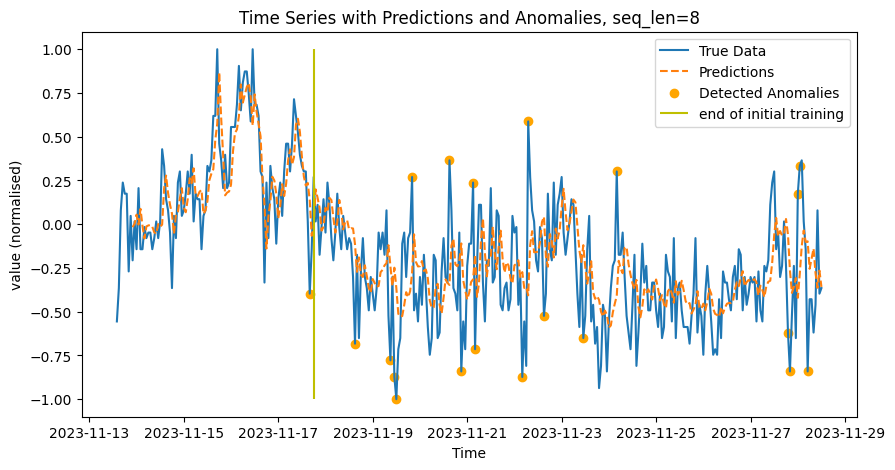

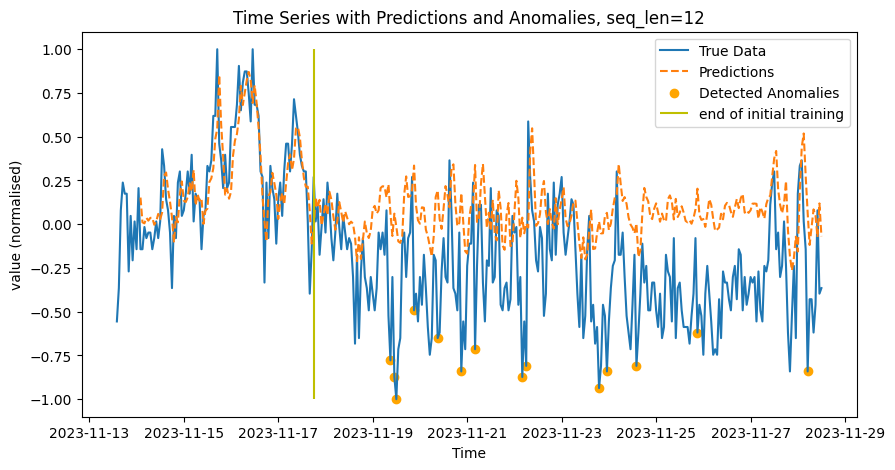

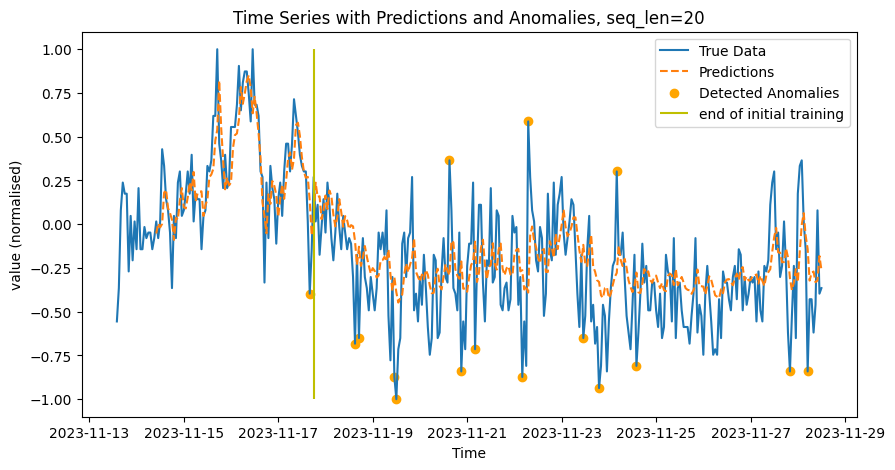

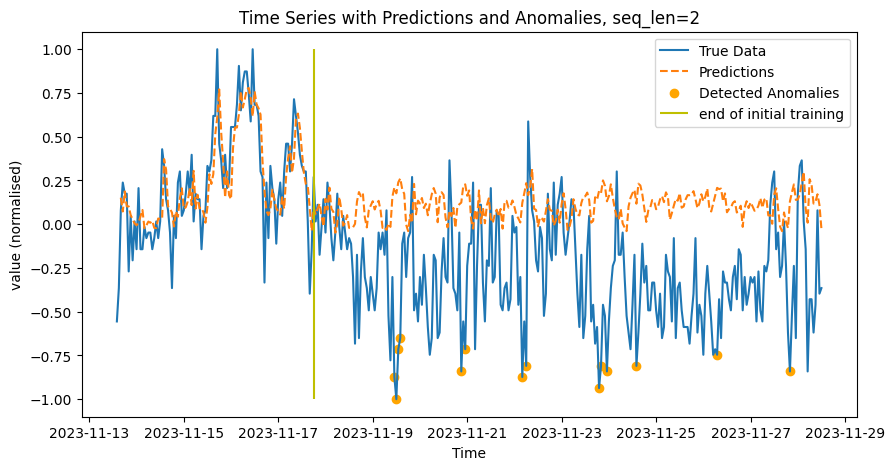

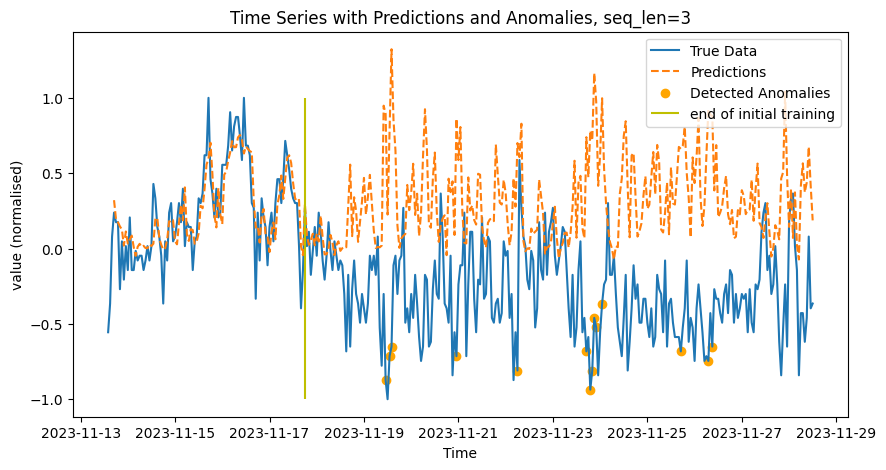

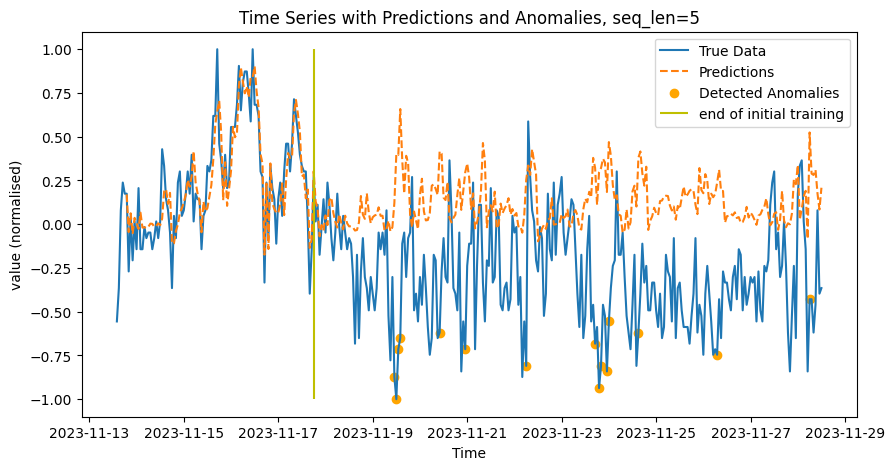

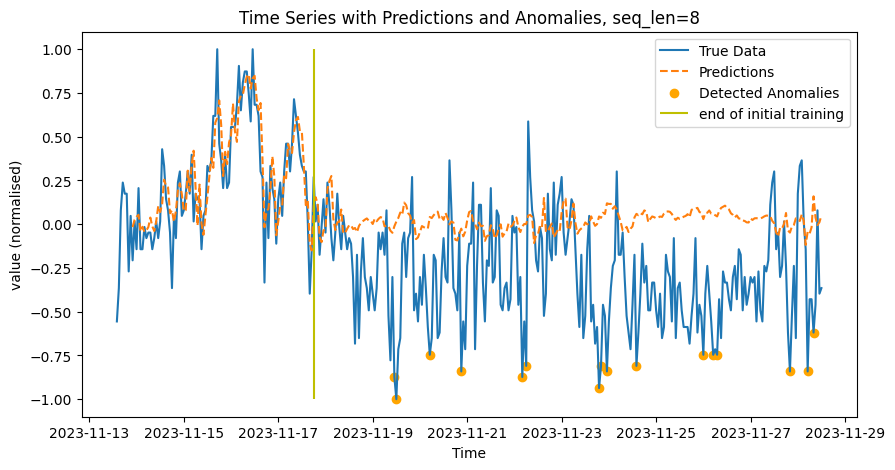

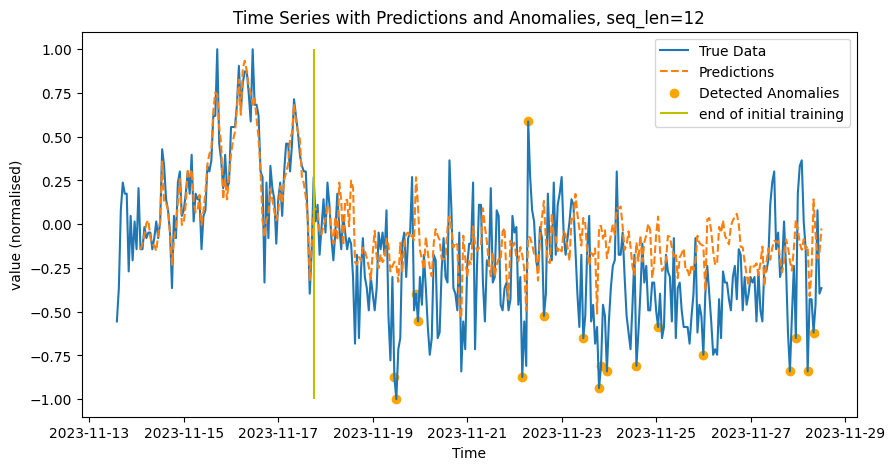

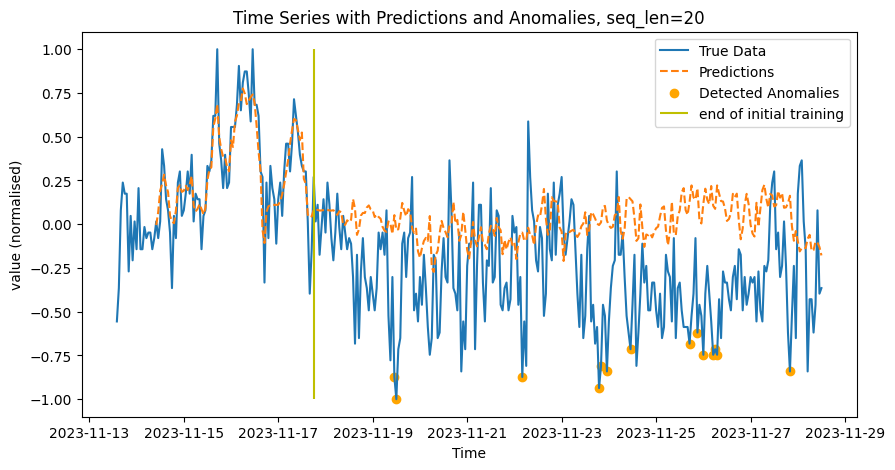

In [20]:
training_series_length = 100

for series_name, series in series_dict.items():
    for model_class in model_classes:
        x, y = preprocess_series(series)
        if series_name == 'series_original':
            anomalies = [49, 61, 69, 91, 94, 175, 231, 347]
        elif series_name == 'series_aug':
            anomalies = []
        for seq_len in seq_lengths:
            set_seed(42)
            model = model_class()
            X, Y = prepare_dataset(y, seq_len)
            train_model(model, X, Y, training_series_length)
            pred = model_predict(model, X)
            detected_anomalies = detect_anomalies(pred, Y, seq_len)
            # saving_path = create_saving_path(model, seq_len, series_name, folder='11_forecaster_loop')
            saving_path = None
            plot_results(x, y, pred, anomalies, detected_anomalies, training_series_length, seq_len, saving_path)

Results dictionary structure:

In [21]:
"""
results = {
    'series_original':{
        'LSTMForecaster': {
            'pred_dict': {'seq_len_1': [], ..., 'seq_len_6': []},
            'detected_anomalies_dict': {'seq_len_1': [], ..., 'seq_len_6': []}},
        'LSTMAttentionForecaster': {
            'pred_dict': {'seq_len_1': [], ..., 'seq_len_6': []},
            'detected_anomalies_dict': {'seq_len_1': [], ..., 'seq_len_6': []}}}, 
    'series_aug': {-||-}
}
"""

"\nresults = {\n    'series_original':{\n        'LSTMForecaster': {\n            'pred_dict': {'seq_len_1': [], ..., 'seq_len_6': []},\n            'detected_anomalies_dict': {'seq_len_1': [], ..., 'seq_len_6': []}},\n        'LSTMAttentionForecaster': {\n            'pred_dict': {'seq_len_1': [], ..., 'seq_len_6': []},\n            'detected_anomalies_dict': {'seq_len_1': [], ..., 'seq_len_6': []}}}, \n    'series_aug': {-||-}\n}\n"

In [22]:
model_classes = [LSTMForecaster, LSTMAttentionForecaster]
# model_classes = [LSTMForecaster]
series_dict = {'series_original': series_original, 'series_aug': series_aug}
# series_dict = {'series_original': series_original}

detected_anomalies_dict = {}
pred_dict = {}
results = {}

training_series_length = 100
colors = ['orange', 'purple', 'seagreen', 'olive', 'saddlebrown', 'palevioletred']

### training and plotting in one cell:

In [23]:
# for series_name, series in series_dict.items():
#     results[series_name] = {}
#     for model_class in model_classes:
#         results[series_name][model_class.__name__] = {}
        
#         detected_anomalies_dict = {}
#         pred_dict = {}
#         anomalies = []
        
#         x, y = preprocess_series(series)
#         if series_name == 'series_original':
#             anomalies = [49, 61, 69, 91, 94, 175, 231, 347]
#         elif series_name == 'series_aug':
#             anomalies = []
#         for i, seq_len in enumerate(seq_lengths):
#             anomalies_tilt = i * .05
#             pred_color=colors[i]
#             set_seed(42)
#             model = model_class()
#             X, Y = prepare_dataset(y, seq_len)
#             train_model(model, X, Y, training_series_length)
#             pred = model_predict(model, X)
#             detected_anomalies = detect_anomalies(pred, Y, seq_len)
            
#             detected_anomalies_dict[seq_len] = detected_anomalies
#             pred_dict[seq_len] = pred

#         results[series_name][model_class.__name__]['pred_dict'] = pred_dict
#         results[series_name][model_class.__name__]['detected_anomalies_dict'] = detected_anomalies_dict
#         # results[series_name][model_class.__name__]['true_anomalies'] = anomalies

#         finetuning=False
#         plt.figure(figsize=(18,10))
        
#         if anomalies != []:
#             plt.scatter(x[anomalies], y[anomalies], s=200, color='red', alpha=1, label="True Anomalies")
            
#         plt.plot(x, y, label="True Data")
#         for i, seq_len in enumerate(seq_lengths):
#             pred = pred_dict[seq_len]
#             detected_anomalies = detected_anomalies_dict[seq_len]
#             pred_color = colors[i]
#             anomalies_tilt = i*.05
            
#             # plot_time_series_all(x, y, anomalies, pred, title=f"Time Series with Predictions and Anomalies, seq_len={seq_len}", pred_color=pred_color)
        
#             if pred is None:
#                 pred_start = 0
#             else:
#                 pred_start = len(x) - len(pred)
#                 # plt.plot(x[pred_start:], pred, label="seq_len=" + str(seq_len) + ", Predictions", linestyle='dashed', color=pred_color, alpha=.5)
#             # plt.xlabel("Time")
#             # if values_normalised:
#             #     plt.ylabel(parameter_name + " (normalised)")
#             # else:
#             #     plt.ylabel(parameter_name)
#             # # plt.title(title)
#             # plt.legend()
            
#             plt.scatter(x[detected_anomalies], y[detected_anomalies] + anomalies_tilt * np.sign(y[detected_anomalies]), color=pred_color,  label="seq_len=" + str(seq_len) + ", Detected Anomalies")
            
        
#         if finetuning:
#             finetuning_ends = list(range(training_series_length + finetuning_step, len(x), finetuning_step))
#             plt.vlines(x[finetuning_ends], -1, 1, colors='y', linestyles='dashed', label='finetuning moments')
#             plt.vlines(x[training_series_length], -1, 1, color='y', label='end of initial training')
        
#         else:
#             plt.vlines(x[training_series_length], -1, 1, color='y', label='end of training series')
        
#         plt.legend(loc='upper left', bbox_to_anchor=(0, -0.05))
#         plt.title('Comparison of anomalies prediction for all tested sequence lengths')
#         plt.suptitle(model_class.__name__ + ', ' + series_name)

### only training (and results dict creation):

In [24]:
for series_name, series in series_dict.items():
    results[series_name] = {}
    for model_class in model_classes:
        results[series_name][model_class.__name__] = {}
        
        detected_anomalies_dict = {}
        pred_dict = {}
        
        x, y = preprocess_series(series)
        if series_name == 'series_original':
            anomalies = [49, 61, 69, 91, 94, 175, 231, 347]
        elif series_name == 'series_aug':
            anomalies = []
        for i, seq_len in enumerate(seq_lengths):
            set_seed(42)
            model = model_class()
            X, Y = prepare_dataset(y, seq_len)
            train_model(model, X, Y, training_series_length)
            pred = model_predict(model, X)
            detected_anomalies = detect_anomalies(pred, Y, seq_len)
            
            detected_anomalies_dict[seq_len] = detected_anomalies
            pred_dict[seq_len] = pred

        results[series_name][model_class.__name__]['pred_dict'] = pred_dict
        results[series_name][model_class.__name__]['detected_anomalies_dict'] = detected_anomalies_dict

### plot prediction_comparison (utilising results dict created in previous cell)

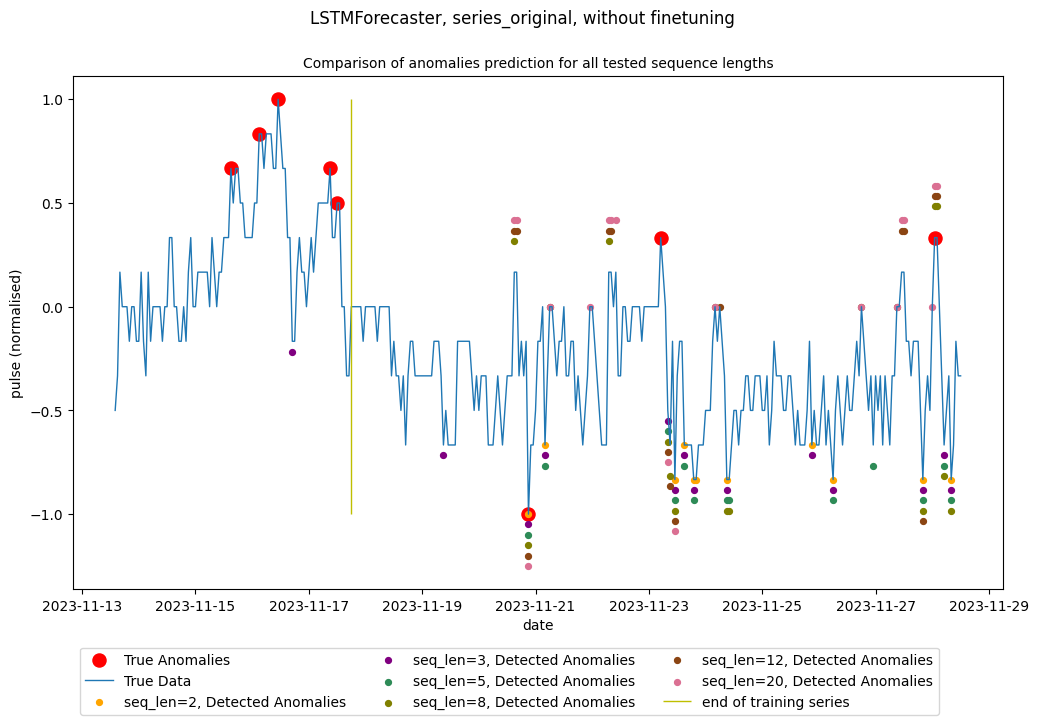

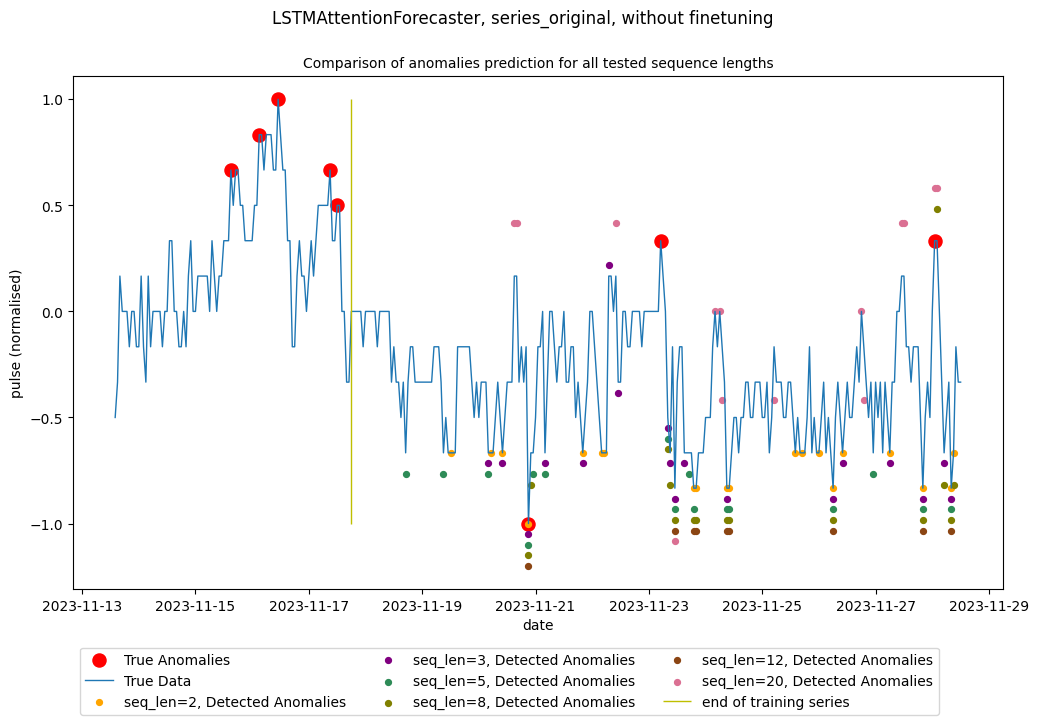

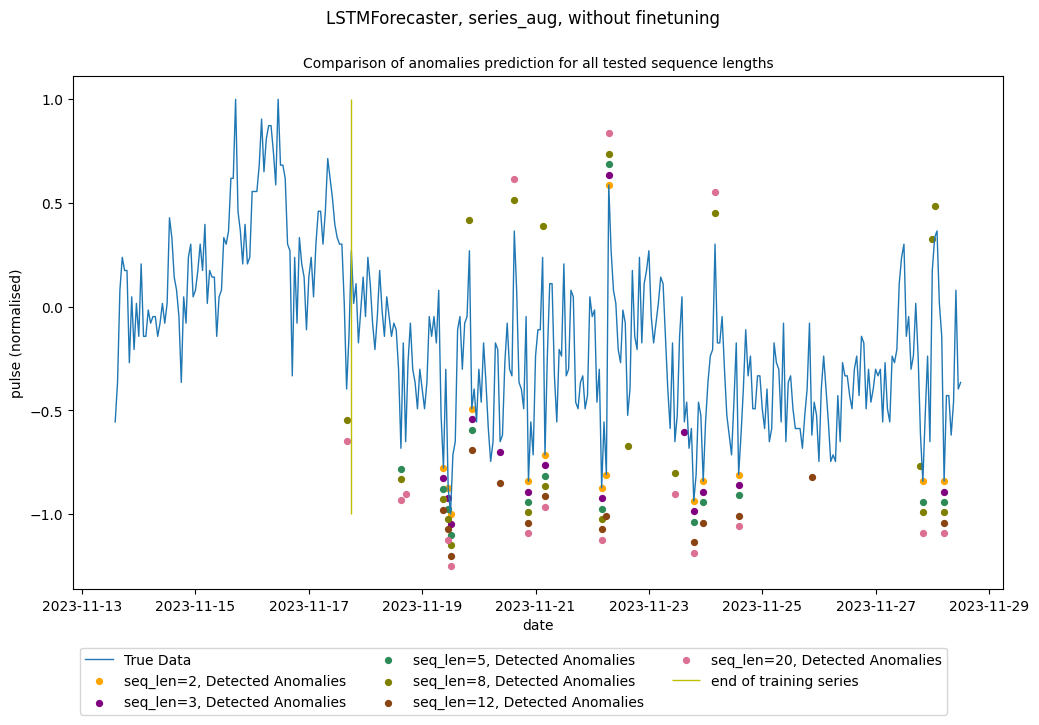

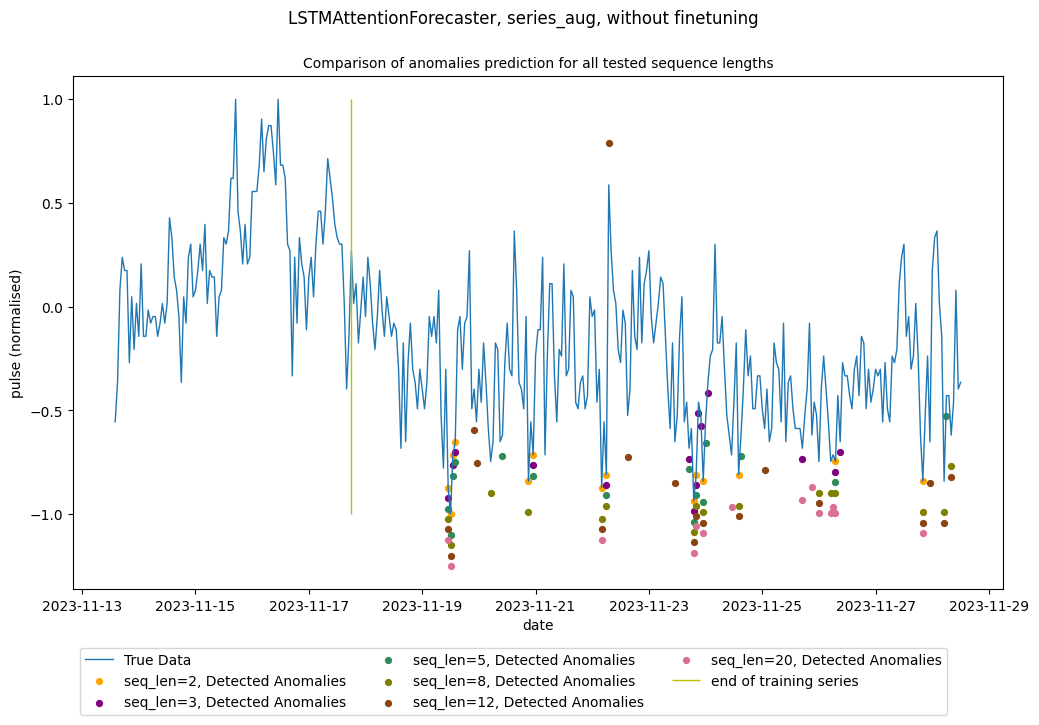

In [25]:
for series_name, series in series_dict.items():
    for model_class in model_classes:  
        detected_anomalies_dict = results[series_name][model_class.__name__]['detected_anomalies_dict']
        pred_dict = results[series_name][model_class.__name__]['pred_dict']
        
        x, y = preprocess_series(series)
        if series_name == 'series_original':
            anomalies = [49, 61, 69, 91, 94, 175, 231, 347]
        elif series_name == 'series_aug':
            anomalies = []
            
        finetuning=False
        fig_scaler = 3/2
        plt.figure(figsize=(18/fig_scaler,10/fig_scaler))
        line_width = 1.5/fig_scaler
        
        if anomalies != []:
            plt.scatter(x[anomalies], y[anomalies], s=200/(fig_scaler**2),
                        color='red', alpha=1, label="True Anomalies")
            
        plt.plot(x, y, label="True Data", linewidth=line_width)
        for i, seq_len in enumerate(seq_lengths):
            pred = pred_dict[seq_len]
            detected_anomalies = detected_anomalies_dict[seq_len]
            pred_color = colors[i]
            anomalies_tilt = i*.05
        
            # if pred is None:
            #     pred_start = 0
            # else:
            #     pred_start = len(x) - len(pred)
            #     plt.plot(
            #         x[pred_start:], pred, label="seq_len=" + str(seq_len) + ", Predictions", 
            #         linestyle='dashed', color=pred_color, alpha=.5)
            
            plt.scatter(
                x[detected_anomalies],
                y[detected_anomalies] + anomalies_tilt * np.sign(y[detected_anomalies]),
                color=pred_color,
                label="seq_len=" + str(seq_len) + ", Detected Anomalies",
                s=40/(fig_scaler**2))
            
        if finetuning:
            finetuning_ends = list(range(training_series_length + finetuning_step,
                                         len(x), finetuning_step))
            plt.vlines(x[finetuning_ends], -1, 1, colors='y', linestyles='dashed',
                       linewidth=line_width, label='finetuning moments')
            plt.vlines(x[training_series_length], -1, 1, color='y', linewidth=line_width,
                       label='end of initial training')
        else:
            plt.vlines(x[training_series_length], -1, 1, color='y',
                       linewidth=line_width, label='end of training series')
        
        plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=3)
        plt.title('Comparison of anomalies prediction for all tested sequence lengths', fontsize = 15/fig_scaler)
        plt.suptitle(model_class.__name__ + ', ' + series_name + ', without finetuning')
        plt.xlabel('date')
        plt.ylabel(param + ' (normalised)')

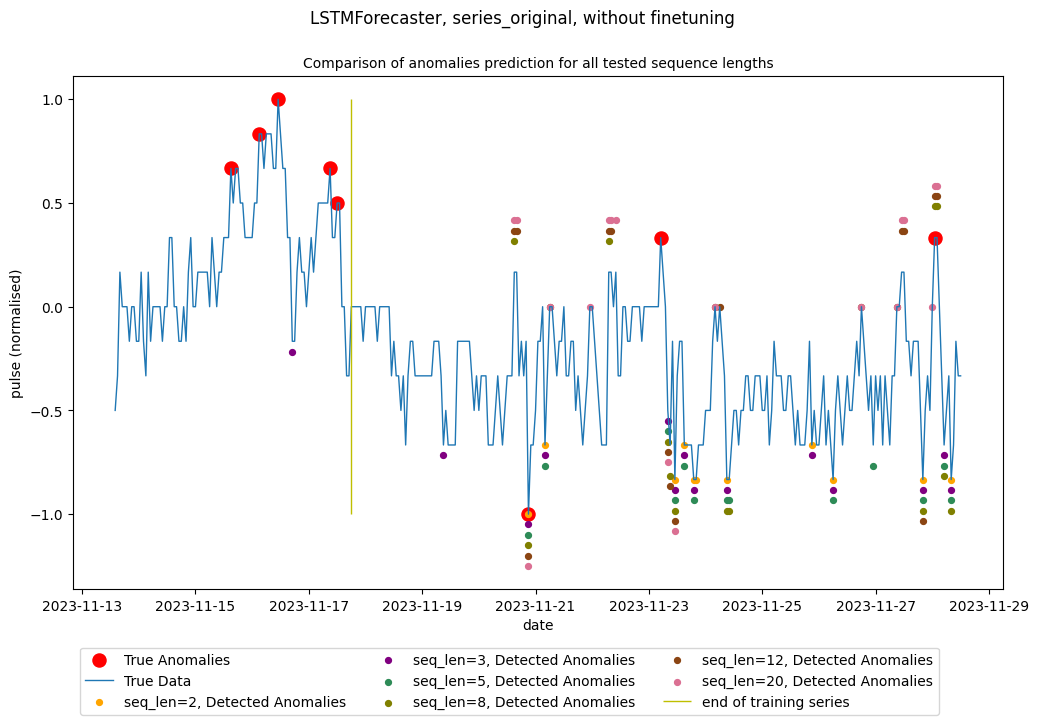

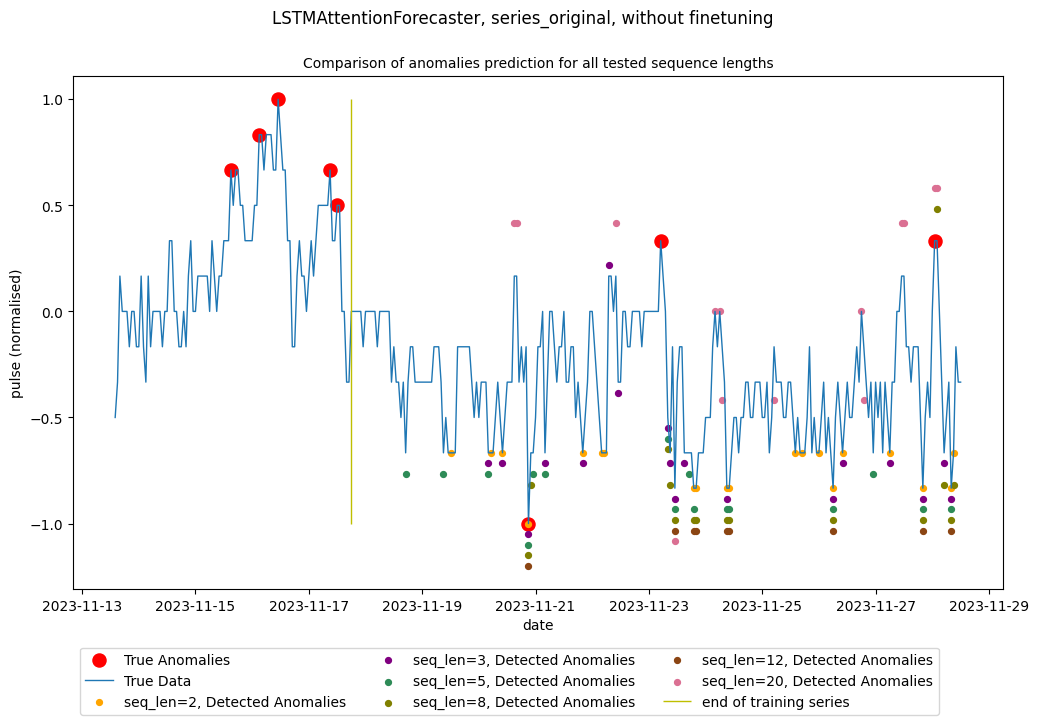

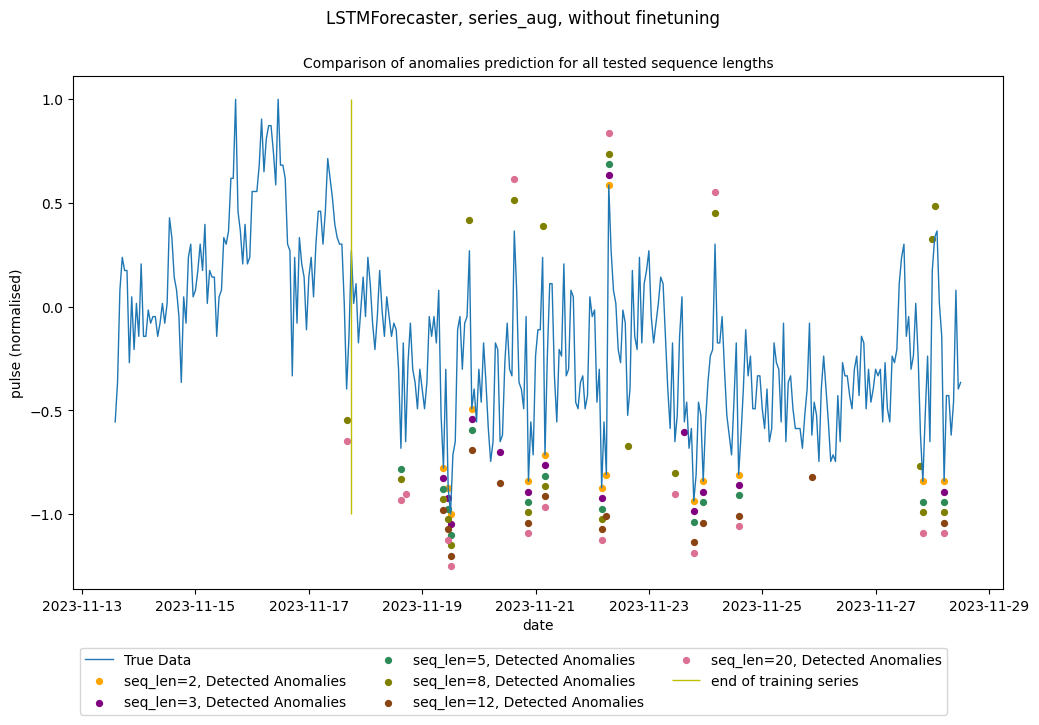

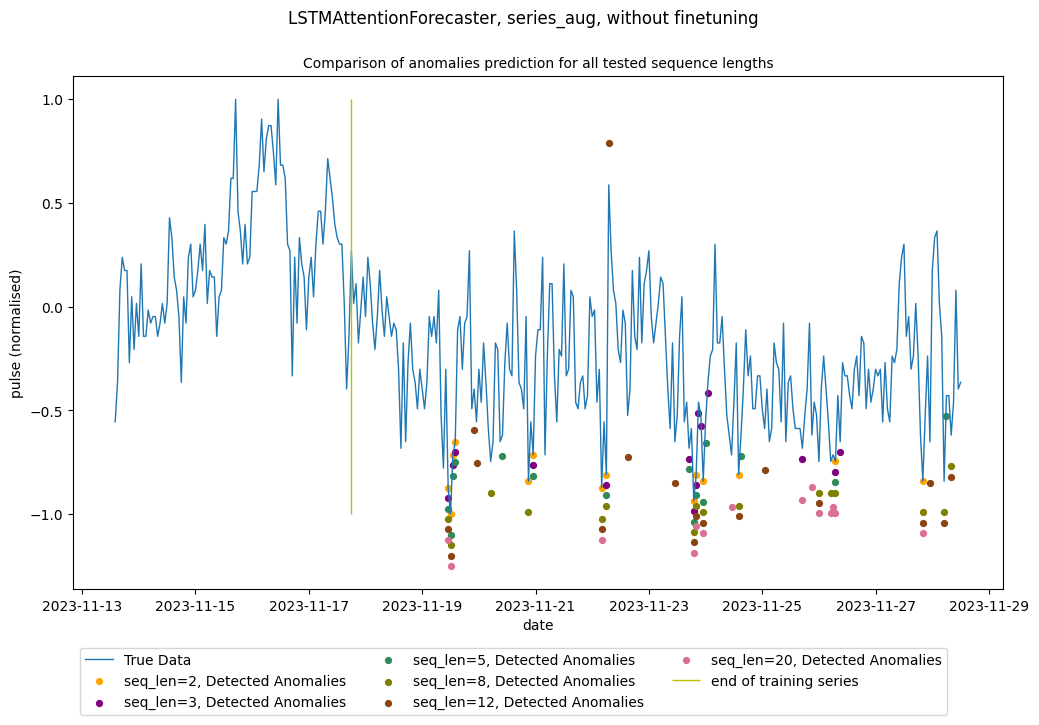

In [26]:
for series_name, series in series_dict.items():
    for model_class in model_classes:  
        detected_anomalies_dict = results[series_name][model_class.__name__]['detected_anomalies_dict']
        pred_dict = results[series_name][model_class.__name__]['pred_dict']
        
        x, y = preprocess_series(series)
        if series_name == 'series_original':
            anomalies = [49, 61, 69, 91, 94, 175, 231, 347]
        elif series_name == 'series_aug':
            anomalies = []
            
        finetuning=False
        fig_scaler = 3/2
        plt.figure(figsize=(18/fig_scaler,10/fig_scaler))
        line_width = 1.5/fig_scaler
        
        if anomalies != []:
            plt.scatter(x[anomalies], y[anomalies], s=200/(fig_scaler**2),
                        color='red', alpha=1, label="True Anomalies")
            
        plt.plot(x, y, label="True Data", linewidth=line_width)
        for i, seq_len in enumerate(seq_lengths):
            pred = pred_dict[seq_len]
            detected_anomalies = detected_anomalies_dict[seq_len]
            pred_color = colors[i]
            anomalies_tilt = i*.05
            
            plt.scatter(
                x[detected_anomalies],
                y[detected_anomalies] + anomalies_tilt * np.sign(y[detected_anomalies]),
                color=pred_color,
                label="seq_len=" + str(seq_len) + ", Detected Anomalies",
                s=40/(fig_scaler**2))
            
        if finetuning:
            finetuning_ends = list(range(training_series_length + finetuning_step,
                                         len(x), finetuning_step))
            plt.vlines(x[finetuning_ends], -1, 1, colors='y', linestyles='dashed',
                       linewidth=line_width, label='finetuning moments')
            plt.vlines(x[training_series_length], -1, 1, color='y', linewidth=line_width,
                       label='end of initial training')
        else:
            plt.vlines(x[training_series_length], -1, 1, color='y',
                       linewidth=line_width, label='end of training series')
        
        plt.legend(loc='upper left', bbox_to_anchor=(0, -0.1), ncol=3)
        plt.title('Comparison of anomalies prediction for all tested sequence lengths',
                  fontsize = 15/fig_scaler)
        plt.suptitle(model_class.__name__ + ', ' + series_name + ', without finetuning')
        plt.xlabel('date')
        plt.ylabel(param + ' (normalised)')